# Reviews classification

In [92]:
import json 
import numpy as np
import pandas as pd

In [93]:
# Data loading
# review.json is 6.3 GB and only first 500.000 records will be loaded.

data_size_review = 100000

with open("../yelp_dataset/yelp_academic_dataset_review.json", 'r') as f:
    review_head = [next(f) for x in range(data_size_review)]
f.close()

review_data = []
for line in review_head:
    review_data.append(json.loads(line))

df = pd.DataFrame(review_data)

print("%i records loaded from review.json, each composed by %i columns." % (df.shape[0], df.shape[1]))

100000 records loaded from review.json, each composed by 9 columns.


In [94]:
size = 10000
train_size = int(size*0.8)
test_size = size-train_size
print(size, train_size)

(10000, 8000)


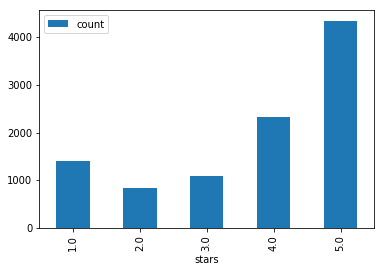

In [95]:
df_count = df[:size].groupby('stars')['stars'].agg(['count'])
df_count.plot.bar()

#### Building the prediction model

We want to build a deep neural network that can rate from 1 to 5 a review given in input. The model will be trained on the review data from Yelp Dataset, in which each review is associated to a star rank from 1 (bad) to 5 (good).

In [96]:
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [97]:
# to train the model we need (input, output) pairs: 
# sentences is the array of inputs and labels is the array of outputs.

sentences = []
for text in df.text:
    sentences.append(text)
    
labels = []
for star in df.stars:
    array = [0 for i in range(5)]
    array[int(star)-1] = 1
    labels.append(array)
    
print(len(sentences), len(labels))

(100000, 100000)


In [98]:
sentences = sentences[:size]
labels = labels[:size]

print(len(sentences), len(labels))

# split the data in (train_data, test_data)
train_sentences = sentences[:train_size]
test_sentences = sentences[train_size:]

train_labels = np.array(labels[:train_size])
test_labels = np.array(labels[train_size:])

print(np.shape(train_sentences), np.shape(test_sentences))
print(np.shape(train_labels), np.shape(test_labels))

(10000, 10000)
((8000,), (2000,))
((8000, 5), (2000, 5))


In [99]:
# Parameters for word embedding

vocab_size = 10000
embedding_dim = 128
max_length = 256

In [100]:
# RUN 1 - Tokenization phase, may takes few minutes

tokenizer = Tokenizer(num_words=vocab_size, oov_token="OOV")
tokenizer.fit_on_texts(train_sentences)
    
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length,
                             padding='post')

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length,
                            padding='post')

print(np.shape(train_padded))
print(np.shape(test_padded))

(8000, 256)
(2000, 256)


In [101]:
# RUN 1 - Compose the model

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 256, 128)          1280000   
_________________________________________________________________
global_average_pooling1d_3 ( (None, 128)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 1,280,645
Trainable params: 1,280,645
Non-trainable params: 0
_________________________________________________________________


In [102]:
# RUN 1 - Train the model

from tensorflow.keras.callbacks import EarlyStopping

epochs = 500
history = []

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
history.append(model.fit(np.array(train_padded), np.array(train_labels), epochs=epochs, 
                       validation_data=(test_padded, test_labels), verbose=2, callbacks=[es]))
model.save_weights('models/model_weights_run1.h5')

Train on 8000 samples, validate on 2000 samples
Epoch 1/500
8000/8000 - 6s - loss: 1.4165 - accuracy: 0.4387 - val_loss: 1.3806 - val_accuracy: 0.4470
Epoch 2/500
8000/8000 - 6s - loss: 1.3364 - accuracy: 0.4717 - val_loss: 1.3210 - val_accuracy: 0.4585
Epoch 3/500
8000/8000 - 6s - loss: 1.2500 - accuracy: 0.4980 - val_loss: 1.2291 - val_accuracy: 0.4905
Epoch 4/500
8000/8000 - 6s - loss: 1.1435 - accuracy: 0.5355 - val_loss: 1.1349 - val_accuracy: 0.5280
Epoch 5/500
8000/8000 - 6s - loss: 1.0465 - accuracy: 0.5727 - val_loss: 1.0665 - val_accuracy: 0.5440
Epoch 6/500
8000/8000 - 6s - loss: 0.9705 - accuracy: 0.6061 - val_loss: 1.0155 - val_accuracy: 0.5785
Epoch 7/500
8000/8000 - 6s - loss: 0.9103 - accuracy: 0.6361 - val_loss: 0.9851 - val_accuracy: 0.5775
Epoch 8/500
8000/8000 - 6s - loss: 0.8615 - accuracy: 0.6582 - val_loss: 0.9525 - val_accuracy: 0.6105
Epoch 9/500
8000/8000 - 6s - loss: 0.8201 - accuracy: 0.6747 - val_loss: 0.9339 - val_accuracy: 0.6185
Epoch 10/500
8000/8000 - 

In [104]:
# RUN 1 - Evaluate the model

_, train_acc = model.evaluate(np.array(train_padded), np.array(train_labels), verbose=0)
_, test_acc = model.evaluate(test_padded, test_labels, verbose=0)
print('Train: %.1f%%, Test: %.1f%%' % (train_acc*100, test_acc*100))
train_ratio = float(train_size)/size
print('Average: %.1f%%' % float((train_acc*train_ratio + test_acc*(1-train_ratio))*100))

Train: 79.8%, Test: 63.7%
Average: 76.6%


In [105]:
# RUN 1 - Compute losses

train_losses = []
test_losses = []

for i in range(len(train_padded)):
    print '\r Progress: ' + str(round(float(i+1)/len(train_padded)*100, 2)) + "%",
    loss, _ = model.evaluate(np.array([train_padded[i]]), np.array([train_labels[i]]), verbose=0)
    train_losses.append([i, loss])

train_losses = sorted(train_losses, key=lambda el: -el[1])

for i in range(len(test_padded)):
    print '\r Progress: ' + str(round(float(i+1)/len(test_padded)*100, 2)) + "%",
    loss, _ = model.evaluate(np.array([test_padded[i]]), np.array([test_labels[i]]), verbose=0)
    test_losses.append([i, loss])

test_losses = sorted(test_losses, key=lambda el: -el[1])

 Progress: 100.0%                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

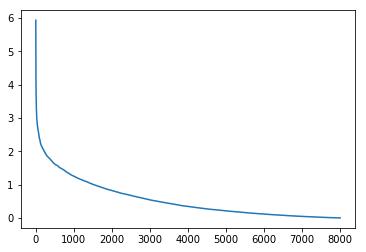

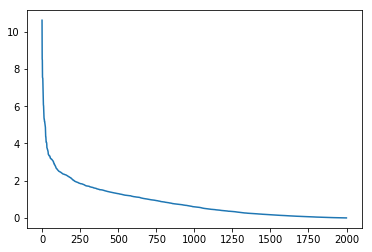

In [106]:
# Run 1 - Plot losses

plt.plot([el[1] for el in train_losses])
plt.show()
plt.plot([el[1] for el in test_losses])
plt.show()

In [107]:
# RUN 1 - Data filtering

remove_indices = list([el[0] for el in filter(lambda el: el[1] > 2, train_losses)])
remove_indices = sorted(remove_indices, reverse=True)

train_sentences2 = [el for i, el in enumerate(train_sentences) if i not in remove_indices]
train_labels2 = np.array([el for i, el in enumerate(train_labels) if i not in remove_indices])

remove_indices = list([el[0] for el in filter(lambda el: el[1] > 2, test_losses)])
remove_indices = sorted(remove_indices, reverse=True)

test_sentences2 = [el for i, el in enumerate(test_sentences) if i not in remove_indices]
test_labels2 = np.array([el for i, el in enumerate(test_labels) if i not in remove_indices])
    
print(np.shape(train_sentences2), np.shape(train_labels2))
print(np.shape(test_sentences2), np.shape(test_labels2))

((7774,), (7774, 5))
((1790,), (1790, 5))


In [108]:
# RUN 2 - Tokenization phase for run 2, may takes few minutes

tokenizer = Tokenizer(num_words=vocab_size, oov_token="OOV")
tokenizer.fit_on_texts(train_sentences2)
    
train_sequences = tokenizer.texts_to_sequences(train_sentences2)
train_padded = pad_sequences(train_sequences, maxlen=max_length,
                             padding='post')

test_sequences = tokenizer.texts_to_sequences(test_sentences2)
test_padded = pad_sequences(test_sequences, maxlen=max_length,
                            padding='post')

print(np.shape(train_padded))
print(np.shape(test_padded))

(7774, 256)
(1790, 256)


In [109]:
# RUN 2 - Compose the model

model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(5, activation='softmax')
])

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 256, 128)          1280000   
_________________________________________________________________
global_average_pooling1d_4 ( (None, 128)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 645       
Total params: 1,280,645
Trainable params: 1,280,645
Non-trainable params: 0
_________________________________________________________________


In [110]:
# RUN 2 - Train the model

epochs = 500
history2 = []

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
history2.append(model2.fit(np.array(train_padded), np.array(train_labels2), epochs=epochs, 
                       validation_data=(test_padded, test_labels2), verbose=2, callbacks=[es]))
model2.save_weights('models/model_weights_run2.h5')

Train on 7774 samples, validate on 1790 samples
Epoch 1/500
7774/7774 - 7s - loss: 1.3971 - accuracy: 0.4475 - val_loss: 1.3229 - val_accuracy: 0.4827
Epoch 2/500
7774/7774 - 8s - loss: 1.3129 - accuracy: 0.4837 - val_loss: 1.2539 - val_accuracy: 0.5017
Epoch 3/500
7774/7774 - 7s - loss: 1.2231 - accuracy: 0.5098 - val_loss: 1.1508 - val_accuracy: 0.5363
Epoch 4/500
7774/7774 - 6s - loss: 1.1159 - accuracy: 0.5427 - val_loss: 1.0414 - val_accuracy: 0.5676
Epoch 5/500
7774/7774 - 6s - loss: 1.0163 - accuracy: 0.5816 - val_loss: 0.9521 - val_accuracy: 0.6056
Epoch 6/500
7774/7774 - 6s - loss: 0.9343 - accuracy: 0.6185 - val_loss: 0.8834 - val_accuracy: 0.6223
Epoch 7/500
7774/7774 - 6s - loss: 0.8718 - accuracy: 0.6478 - val_loss: 0.8314 - val_accuracy: 0.6659
Epoch 8/500
7774/7774 - 6s - loss: 0.8153 - accuracy: 0.6710 - val_loss: 0.7880 - val_accuracy: 0.6777
Epoch 9/500
7774/7774 - 6s - loss: 0.7687 - accuracy: 0.6912 - val_loss: 0.7552 - val_accuracy: 0.6777
Epoch 10/500
7774/7774 - 

In [111]:
# RUN 2 - Evaluate the model

_, train_acc = model2.evaluate(np.array(train_padded), np.array(train_labels2), verbose=0)
_, test_acc = model2.evaluate(test_padded, test_labels2, verbose=0)
print('Train: %.1f%%, Test: %.1f%%' % (train_acc*100, test_acc*100))
train_ratio = float(train_size)/size
print('Average: %.1f%%' % float((train_acc*train_ratio + test_acc*(1-train_ratio))*100))

Train: 88.9%, Test: 70.3%
Average: 85.2%


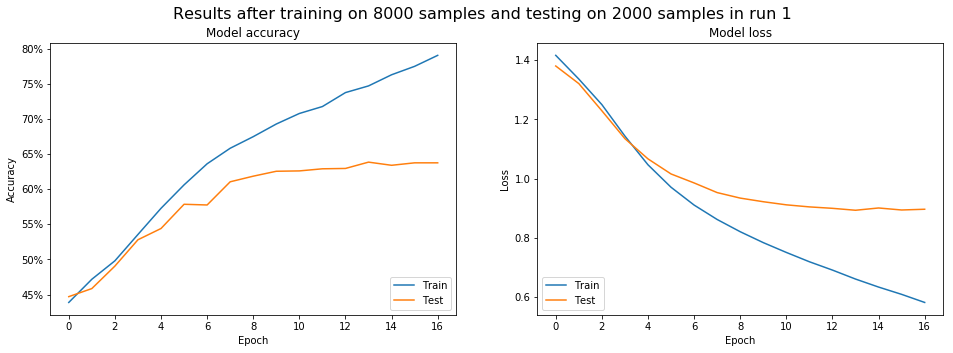

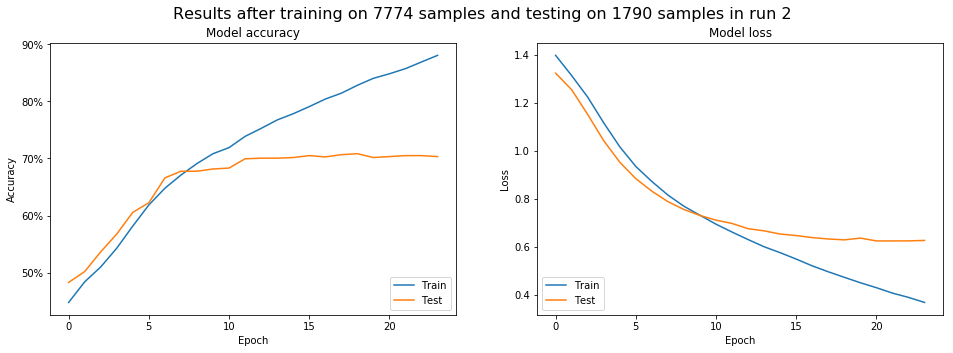

In [118]:
# RUN 1 - Plot results

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


for i in range(len(history)):

    fig, axes = plt.subplots(1, 2, figsize=(16,5))
    fig.suptitle('Results after training on %i samples and testing on %i samples in run 1' 
                 % (len(train_sentences), len(test_labels)), fontsize=16)

    # summarize history for accuracy
    axes[0].plot(history[i].history['accuracy'])
    axes[0].plot(history[i].history['val_accuracy'])
    axes[0].set_title('Model accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Test'], loc='lower right')

    # summarize history for loss
    axes[1].plot(history[i].history['loss'])
    axes[1].plot(history[i].history['val_loss'])
    axes[1].set_title('Model loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Test'], loc='lower left')

    plt.show()
    
for i in range(len(history2)):

    fig, axes = plt.subplots(1, 2, figsize=(16,5))
    fig.suptitle('Results after training on %i samples and testing on %i samples in run 2' 
                 % (len(train_sentences2), len(test_labels2)), fontsize=16)

    # summarize history for accuracy
    axes[0].plot(history2[i].history['accuracy'])
    axes[0].plot(history2[i].history['val_accuracy'])
    axes[0].set_title('Model accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Test'], loc='lower right')

    # summarize history for loss
    axes[1].plot(history2[i].history['loss'])
    axes[1].plot(history2[i].history['val_loss'])
    axes[1].set_title('Model loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Test'], loc='lower left')

    plt.show()

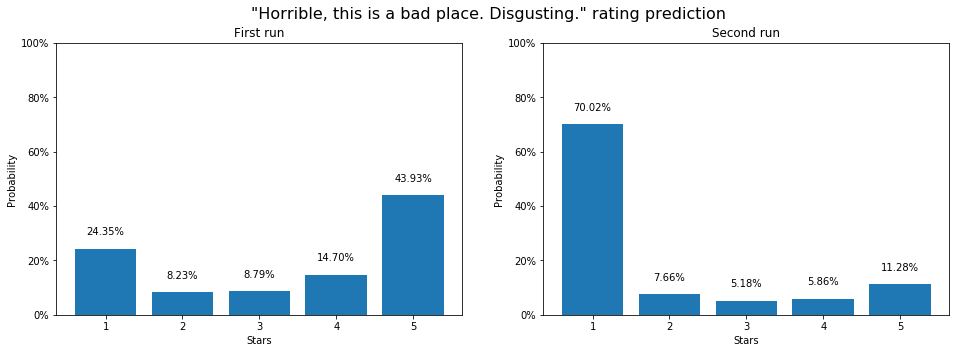

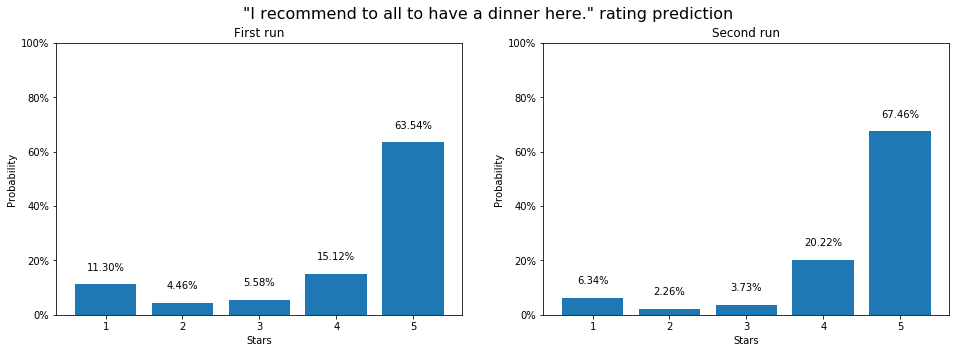

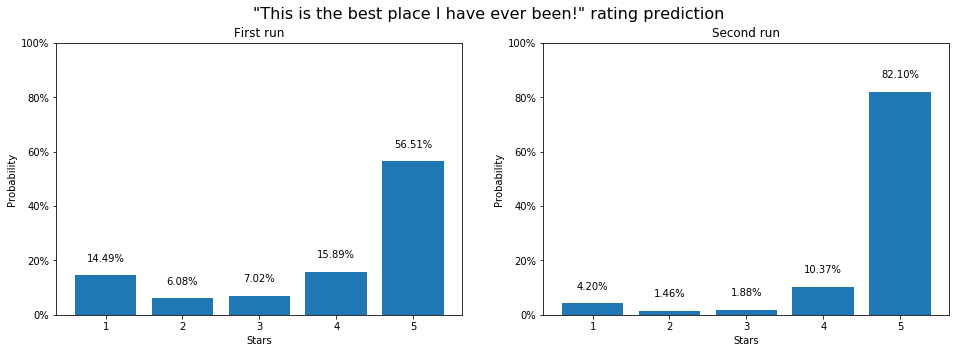

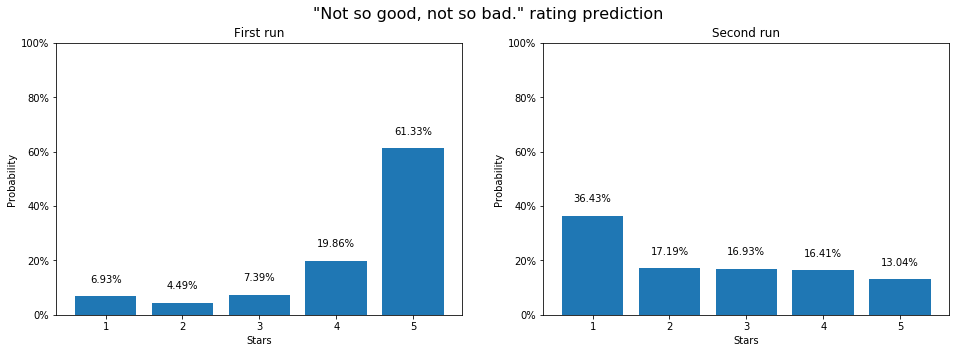

In [115]:
# Make prediction

sentences_p = [
    "Horrible, this is a bad place. Disgusting.",
    "I recommend to all to have a dinner here.",
    "This is the best place I have ever been!",
    "Not so good, not so bad."
]

sequences_p = tokenizer.texts_to_sequences(sentences_p)
padded_p = pad_sequences(sequences_p, maxlen=max_length, padding='post')

result = model.predict(padded_p)
result2 = model2.predict(padded_p)

for i in range(len(result)):    
    fig, axes = plt.subplots(1, 2, figsize=(16,5))
    fig.suptitle('"%s" rating prediction' % sentences_p[i], fontsize=16)

    # run 1
    axes[0].bar([k+1 for k in range(5)], [result[i][j] for j in range(5)])
    axes[0].set_title('First run')
    axes[0].set_ylabel('Probability')
    axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    axes[0].set_xlabel('Stars')
    axes[0].set_ylim(0, 1)
    for h, v in enumerate(result[i]):
        axes[0].text(h+1, v+0.05, ("%.2f%%" % float(v*100)), horizontalalignment='center')

    # run 2
    axes[1].bar([k+1 for k in range(5)], [result2[i][j] for j in range(5)])
    axes[1].set_title('Second run')
    axes[1].set_ylabel('Probability')
    axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    axes[1].set_xlabel('Stars')
    axes[1].set_ylim(0, 1)
    for h, v in enumerate(result2[i]):
        axes[1].text(h+1, v+0.05, ("%.2f%%" % float(v*100)), horizontalalignment='center') 

    plt.show()